In [1]:
%%capture
%run 01_Data_Preparation.ipynb

## Gaussian Process Regressor

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, DotProduct

In [3]:
X_train = z.reshape(-1, 1)
y_train = mu

In [4]:
X_train.shape,y_train.shape

((308, 1), (308,))

In [5]:
np.min(X_train)

0.0163

In [6]:
np.max(X_train)

7.08

In [7]:
# input for predictions
X_pred = np.linspace(0.01, 8, 1000).reshape(-1,1)

In [8]:
# Instantiate a Gaussian Process model
kernel = ConstantKernel() + 1.0 * DotProduct() ** 0.1
# ConstantKernel() + 1.0 * DotProduct() ** 0.1 + 1.0 * WhiteKernel()

gpr = GaussianProcessRegressor(
    kernel=kernel, 
    alpha=0.3, 
    normalize_y=True, 
    random_state=123, 
    n_restarts_optimizer=100
)

In [9]:
def plot_gpr_samples(gpr_model, X, n_samples, ax):
    
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    
    y_mean, y_std = gpr_model.predict(X.reshape(-1,1), return_std=True)
    y_samples = gpr_model.sample_y(X.reshape(-1,1), n_samples)
    
    x = X.reshape(-1)
    
    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            #label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - 2*y_std,
        y_mean + 2*y_std,
        alpha=0.2,
        color="blue",
        label=r"$\pm$ 2 std. dev.",
    )
    ax.set_xlabel("redshfit (z)")
    ax.set_ylabel("distance modulus ($\mu$)")
    #ax.set_ylim([-3, 3])
    ax.legend()

c:\Users\Sarvesh Purohit\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:492: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T
C:\Users\Sarvesh Purohit\AppData\Local\Temp\ipykernel_23648\631166607.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


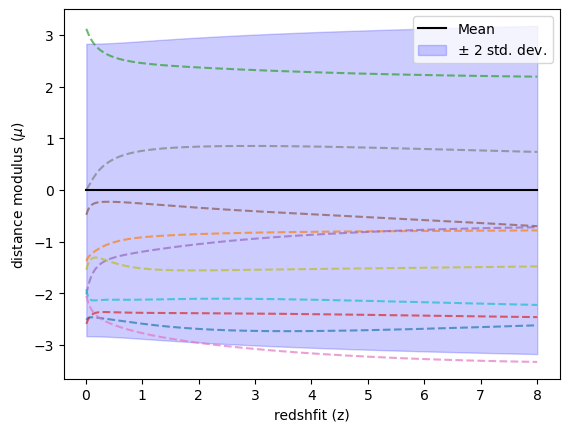

In [10]:
fig, ax = plt.subplots()
plot_gpr_samples(gpr, X_pred, 10, ax)
#ax.set_title('Samples from prior disribution')
fig.savefig(os.path.join(out_dir,'02_Sample_prior_distibutions.pdf'))
fig.show()

In [11]:
gpr.fit(X_train, y_train)

print(
    f"Kernel parameters before fit:\n{kernel} \n"
    f"Kernel parameters after fit: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f} \n"
    f"Score = {gpr.score(X_train,y_train)}"
)

Kernel parameters before fit:
1**2 + 1**2 * DotProduct(sigma_0=1) ** 0.1 
Kernel parameters after fit: 
8.28**2 + 7.82**2 * DotProduct(sigma_0=0.0102) ** 0.1 
Log-likelihood: -270.990 
Score = 0.6833282563050915


c:\Users\Sarvesh Purohit\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:492: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T
C:\Users\Sarvesh Purohit\AppData\Local\Temp\ipykernel_23648\3638918824.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


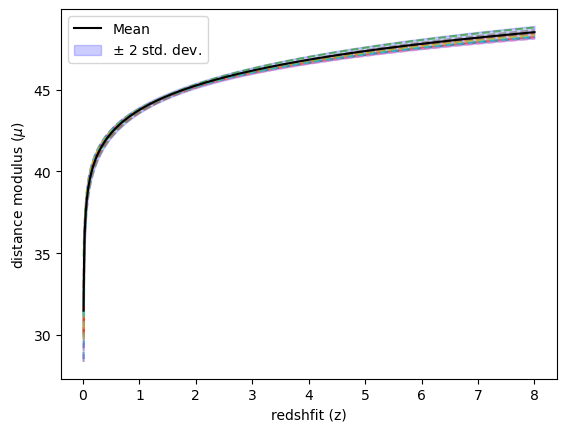

In [12]:
fig, ax = plt.subplots()
plot_gpr_samples(gpr, X_pred, 10, ax)
#ax.set_title('Samples from posterior disribution')
fig.savefig(os.path.join(out_dir,'02_Sample_posterior_distibutions.pdf'))
fig.show()

In [15]:
y_pred.shape

(1000,)

In [16]:
y_pred, sigma = gpr.predict(X_pred, return_std=True)
y_pred = y_pred.reshape(-1)

In [17]:
y_pred.shape

(1000,)

In [18]:
df_SNe['z'].shape

(2421,)

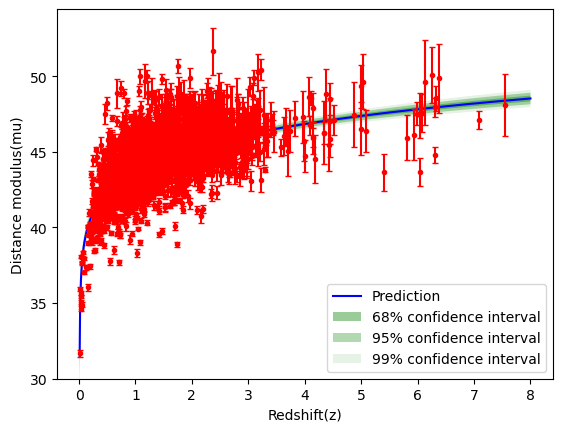

In [22]:
#plt.figure(figsize=(7,5))
#plt.plot(X_train, y_train, 'r.', markersize=3, label='Observations')
plt.plot(X_pred, y_pred, 'b-', label='Prediction',)

(_, caps, _) = plt.errorbar(df_SNe['z'], df_SNe['DM'],yerr=df_SNe['e_DM'], fmt='.',color='r',capsize=2)

for cap in caps:
    cap.set_markeredgewidth(1)

# plt.errorbar(df_SNe['z'], df_SNe['DM'],yerr=df_SNe['e_DM'], fmt='.',color='r')
plt.fill_between(X_pred[:,0], y_pred-1*sigma, y_pred+1*sigma,
         alpha=.4, fc='g', ec='None', label='68% confidence interval')
plt.fill_between(X_pred[:,0], y_pred-2*sigma, y_pred+2*sigma,
         alpha=.3, fc='g', ec='None', label='95% confidence interval')
plt.fill_between(X_pred[:,0], y_pred-3*sigma, y_pred+3*sigma,
         alpha=.1, fc='g', ec='None', label='99% confidence interval')
plt.xlabel('Redshift(z)')
plt.ylabel('Distance modulus(mu)')
#plt.title('The reconstruction of distance moduli from '+dataset+' data using Gaussian process')
plt.legend()

plt.savefig(os.path.join(out_dir,'03_Reconstruction_GP.pdf'))
plt.ylim(bottom=30)
plt.show()